# MNIST with PyTorch

In this notebook example, we will walk through how to train a simple CNN to classify MNIST images.

We will rely on the following modules, including torch and torchvision.

In [3]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4MB 23kB/s 
     |████████████████████████████████| 6.6MB 11.4MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

## 1. Data Loader

The first step is to create a data loader.

A data loader can be treated as a list (or iterator, technically). Each time it will provide a minibatch of (img, label) pairs.

In [4]:
# Choose a dataset -- MNIST for example
train_set = datasets.MNIST(root='./data', train=True, download=True)
test_set = datasets.MNIST(root='./data', train=False, download=True)

train_set.transform = transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])

test_set.transform = transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])

# Create a data loader
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Let us show some of the training images, for fun.

In [2]:
def imshow(img, mean=0, std=1):
    img = img * std + mean  # unnormalize
    npimg = img.numpy().transpose(1, 2, 0).squeeze()  # (c,h,w) -> (h,w,c)
    plt.imshow(npimg)
    plt.show()
    
trainiter = iter(train_loader)
img, label = trainiter.next()
print(img.shape)  # (n,c,h,w)

# Visualization
img = torchvision.utils.make_grid(img)
imshow(img, 0.1307, 0.3081)
print('GT\t:', ' '.join('%d' % label[j].item() for j in range(len(label))))

NameError: ignored

In [78]:
# To check a single random image

trainiter = iter(train_loader)
img, label = trainiter.next()
plt.imshow(img[0].reshape(28,28), cmap="gray")

## 2. Model

The second step is to define our model.

We will use a simple CNN with conv(5x5) -> relu -> pool(2x2) -> conv(5x5) -> relu -> pool(2x2) -> fc(200) -> relu  -> fc(10).

In PyTorch, a model is defined by a subclass of nn.Module. It has two methods:

  - `__init__`: constructor. Create layers here. Note that we don't define the connections between layers in this function.

  - `forward(x)`: forward function. Receives an input variable `x`. Returns a output variable. Note that we actually connect the layers here dynamically.

We no longer need to implement the backward function. The computational graph will be built implicitly based on the forward operations, and the gradients can be automatically computed.

In [30]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()  # Call parent class's constructor
        self.conv1 = nn.Conv2d(1, 10, 5, 1)
        self.conv2 = nn.Conv2d(10, 20, 5, 1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(4*4*20, 200)
        self.fc2 = nn.Linear(200, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x) # When a nn.Module is called, it will compute the result
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 4*4*20) # Flatten the data
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()

You can double check your model specification.

In [45]:
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
  (relu): ReLU()
)


Let us test with random inputs.

In [31]:
x = torch.rand([64,1,28,28])
y = model(x)
print(y.shape)

torch.Size([64, 10])


## 3. Loss and Optimizer

The third step is to define the loss function and the optimization algorithm. Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [33]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), 0.01, momentum=0.9, weight_decay=5e-4)

## 4. Training

The next step is to start the training process.

In [34]:
def train(epoch):
    model.train()  # Set the model to be in training mode

    for batch_index, (inputs, targets) in enumerate(train_loader):
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        if batch_index % 100 == 0 or batch_index == len(train_loader)-1:
            print('epoch {}  batch {}/{}  loss {:.3f}'.format(
                epoch, batch_index, len(train_loader)-1, loss.item()))

        # Backward
        optimizer.zero_grad()  # Set gradients to zero
        loss.backward()        # From the loss we compute the new gradients
        optimizer.step()       # Update the parameters/weights


'zero_grad' is to clear previous gradients. We need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.

Now let us train the network for 1 pass over the training dataset, and check if the network has learned anything at all.

In [35]:
train(0)

epoch 0  batch 0/937  loss 2.310
epoch 0  batch 100/937  loss 0.223
epoch 0  batch 200/937  loss 0.168
epoch 0  batch 300/937  loss 0.054
epoch 0  batch 400/937  loss 0.076
epoch 0  batch 500/937  loss 0.174
epoch 0  batch 600/937  loss 0.052
epoch 0  batch 700/937  loss 0.063
epoch 0  batch 800/937  loss 0.090
epoch 0  batch 900/937  loss 0.018
epoch 0  batch 937/937  loss 0.007


## 5. Plotting Training Curve

How do we know when to stop training? How do we know what learning rate and what batch sizes are appropriate? Those are very important and practical questions to answer when training a neural network. We answer those questions by plotting a **training curve**.

A **training curve** is a chart that shows:
1.   The **iterations** or **epochs** on the x-axis
2.   The **loss** or **accuracy** on the y-axis

The idea is to track how the loss or accuracy changes as training progresses.

Let's redefine the training process.

In [41]:
def train(epoch):
    model.train()  # Set the model to be in training mode

    iters  = [] # save the iteration counts here for plotting
    losses = [] # save the avg loss here for plotting

    for batch_index, (inputs, targets) in enumerate(train_loader):
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        if batch_index % 100 == 0 or batch_index == len(train_loader)-1:
            print('epoch {}  batch {}/{}  loss {:.3f}'.format(
                epoch, batch_index, len(train_loader)-1, loss.item()))

        # Backward
        optimizer.zero_grad()  # Set gradients to zero
        loss.backward()        # From the loss we compute the new gradients
        optimizer.step()       # Update the parameters/weights

        # Save the current training information
        iters.append(batch_index)
        losses.append(float(loss))

    # Plotting
    plt.plot(iters, losses)
    plt.title("Training Curve")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

Let's try the training again for 1 epoch.

In [21]:
model = SimpleCNN()

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), 0.01, momentum=0.9, weight_decay=5e-4)

train(0)

epoch 0  batch 0/937  loss 2.320
epoch 0  batch 100/937  loss 0.275
epoch 0  batch 200/937  loss 0.144
epoch 0  batch 300/937  loss 0.117
epoch 0  batch 400/937  loss 0.034
epoch 0  batch 500/937  loss 0.219
epoch 0  batch 600/937  loss 0.089
epoch 0  batch 700/937  loss 0.257
epoch 0  batch 800/937  loss 0.013
epoch 0  batch 900/937  loss 0.170
epoch 0  batch 937/937  loss 0.279


The first thing that you might notice is that the loss is a bit noisy. Some people choose to plot a running average of the loss to remove some of the noise.

You can try how the training curve changes as we change the batch size and the learning rate.



##6. Visualizing Filters

In this section, we will look into the practical aspects and code for visualizing filters.

We first create a model_weights list to save the weights of all the convolutional layers. 

Next, we are getting all the model children as list and storing them in the model_children list. This will allow us to easily access the hidden layers.

In [51]:
model_weights = [] # We will save the conv layer weights in this list

# Get all the model children as list
model_children = list(model.children())

We will have to traverse through all these nestings to retrieve the convolutional layers and their weights.

The following code shows how to retrieve all the convolutional layers and their weights.

In [52]:
# Counter to keep count of the conv layers
counter = 0 

# Append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)

    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)

print(f"Total convolutional layers: {counter}")

Total convolutional layers: 2


For the sake of simplicity, we will only visualize the filters of the first convolutional layer.

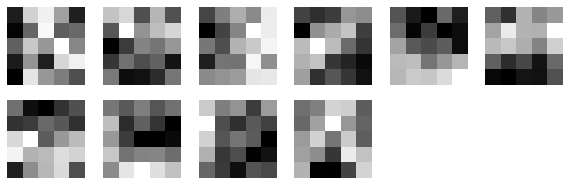

In [53]:
# Visualize the first conv layer filters
plt.figure(figsize=(10, 10))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(6, 6, i+1) # (6, 6) because in conv1 we have 5x5 filters and total of 10 
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('filter.png')
plt.show()

## 7. Testing

Let's define the test and visualize functions now.

In [36]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item() * inputs.size(0) # Sum up batch loss
            preds = outputs.max(1, keepdim=True)[1] # Get the index of the max probability
            correct += preds.eq(targets.view_as(preds)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    

def visualize():
    model.eval()
    testiter = iter(test_loader)
    inputs, targets = testiter.next()
    
    with torch.no_grad():
        outputs = model(inputs)
        preds = outputs.max(1, keepdim=True)[1]
        print(preds.shape)
    
    img = torchvision.utils.make_grid(inputs)
    imshow(img, 0.1307, 0.3081)
    print('GT\t:', ' '.join('%d' % targets[j].item() for j in range(len(targets))))
    print('Pred\t:', ' '.join('%d' % preds[j].item() for j in range(len(targets))))

Let's do the test and visualize the results on the model that we have just trained for 1 epoch.


Test set: Average loss: 0.0482, Accuracy: 9838/10000 (98.38%)

torch.Size([64, 1])


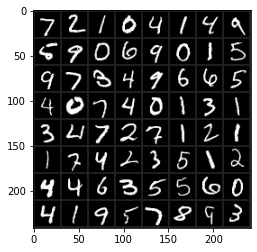

GT	: 7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3
Pred	: 7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3


In [37]:
test()
visualize()

It seems pretty good! Let us try more epochs.

epoch 1  batch 0/937  loss 0.051
epoch 1  batch 100/937  loss 0.175
epoch 1  batch 200/937  loss 0.006
epoch 1  batch 300/937  loss 0.069
epoch 1  batch 400/937  loss 0.140
epoch 1  batch 500/937  loss 0.024
epoch 1  batch 600/937  loss 0.035
epoch 1  batch 700/937  loss 0.056
epoch 1  batch 800/937  loss 0.081
epoch 1  batch 900/937  loss 0.081
epoch 1  batch 937/937  loss 0.146

Test set: Average loss: 0.0398, Accuracy: 9873/10000 (98.73%)

epoch 2  batch 0/937  loss 0.066
epoch 2  batch 100/937  loss 0.066
epoch 2  batch 200/937  loss 0.085
epoch 2  batch 300/937  loss 0.034
epoch 2  batch 400/937  loss 0.067
epoch 2  batch 500/937  loss 0.044
epoch 2  batch 600/937  loss 0.031
epoch 2  batch 700/937  loss 0.143
epoch 2  batch 800/937  loss 0.032
epoch 2  batch 900/937  loss 0.041
epoch 2  batch 937/937  loss 0.007

Test set: Average loss: 0.0343, Accuracy: 9893/10000 (98.93%)

epoch 3  batch 0/937  loss 0.019
epoch 3  batch 100/937  loss 0.013
epoch 3  batch 200/937  loss 0.010
epo

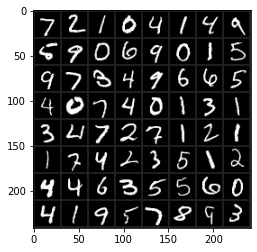

GT	: 7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3
Pred	: 7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 4 7 2 7 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3


In [13]:
for epoch in range(1, 4):
    train(epoch)
    test()

visualize()

## 8. Checkpointing

Normally, we will train our neural network for not just one epoch, but many. Neural network training typically takes a long time, sometimes days, weeks, or even months. Our training code should therefore be robust to interruptions. That is, we should write our training code so that we can save and re-load weights.

It is good to **checkpoint** training progress by saving the neural network parameter values and training curve data to disk, once every few epochs. The frequency of checkpointing depends on many factors, but I recommend checkpointing every 10-30 minutes for large projects, and every few minutes for smaller ones.

Another advantage of checkpointing is that we now have one extra hyper-parameter we can tune for free: the **epoch** number! You may not wish to choose neural network parameter values at the end of training, and might opt to choose the parameter values at a different epoch of training.

One reason you might opt to do so is to prevent **over-fitting**. If your training loss is decreasing (as training progresses), but your validation loss stays the same, then your network is beginning to learn idiosyncrasies of the training set that do not generalize. Most often, we choose the earliest epoch with the lowest validation loss or error.

Saving and loading a model in PyTorch is very easy and straight forward.
It’s as simple as this:

In [38]:
checkpoint = {'model_state_dict': model.state_dict(),
          'optimizer_state_dict' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

Loading is as simple as saving

1. Reconstruct the model from the structure saved in the checkpoint.
2. Load the state dict to the model.
3. Use model.eval() to freeze the parameters and enter evaluation mode if you are loading the model for inference. If you wish to resuming training, call model.train() to ensure these layers are in training mode.

In [39]:
model = SimpleCNN()
optimizer = torch.optim.SGD(model.parameters(), 0.01, momentum=0.9, weight_decay=5e-4)

checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.eval()

test()

SimpleCNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=10, bias=True)
  (relu): ReLU()
)

## 9. What's Next?

We have sketched a simple framework for training CNNs. There are a few more functions yet to be completed.

  - Adjust the learning rate and batch size and observe the training curve
  - Plot a chart for the accuracy
  - Average the loss during each epoch when plotting a chart
  - Consider data augmentations

Please check the official [Tutorials](https://pytorch.org/tutorials) and [Examples](https://github.com/pytorch/examples) on for more details.